#### Includes

In [1]:
%load_ext autoreload
%autoreload 2

In [136]:
import numpy as np
import torch
import torch.nn.functional as F
import altair as alt
from altair import datum
import plotly.express as px
from plotly.subplots import make_subplots
import time
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 5)

In [4]:
from sources import load_dataset, parse_config, setup_model
from steered_cnn.utils.rotequivariance_toolbox import *
from steered_cnn.steered_conv.steerable_filters import radial_steerable_filter, plot_filter
from steered_cnn.utils import clip_pad_center
from steered_cnn.steered_conv import SteerableKernelBase, OrthoKernelBase
from steered_cnn.models import SteeredHemelingNet, HemelingNet
from src.trainer import Binary2DSegmentation

In [5]:
torch.set_printoptions(precision=3, sci_mode=False)

In [53]:
def as_angle(alpha, modulo=2*np.pi, symetric=True):
    alpha = alpha%modulo
    half_mod = modulo/2
    if symetric:
        alpha[alpha>half_mod] -= modulo
    return alpha

## Orientation Detection

#### Generating a Directional Map

In [13]:
base = SteerableKernelBase.create_radial(5, oversample=4)

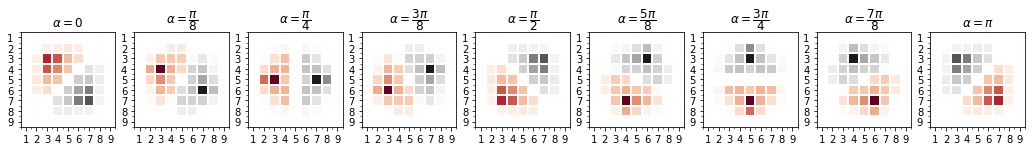

In [188]:
x = torch.linspace(-2,2,5)
x,y = torch.meshgrid(x,x)
K = (x+y)/4
K = K.reshape(1,1,5,5)
K = clip_pad_center(K, base.base.shape)

info = {}
Wdiamond = base.approximate_weights(K, info)

I = torch.zeros((1,1,9,9))
I[:,:,4,4] = 1
N = 8
fig, axs = plt.subplots(1,N+1)
alphas = np.linspace(0, np.pi, N+1, endpoint=True)
diamond_rot = []
rotations_label = []
for i in range(N+1):
    r = base.conv2d(I,Wdiamond, alpha=alphas[i])[0,0]
    plot_filter(r, plot=axs[i], vmax=1)
    axs[i].set_title(f'$\\alpha = {repr_pi_fraction(i,N)}$')
    diamond_rot += [r]
    rotations_label += [repr_pi_fraction(i,N)]
diamond_rot = torch.stack(diamond_rot)

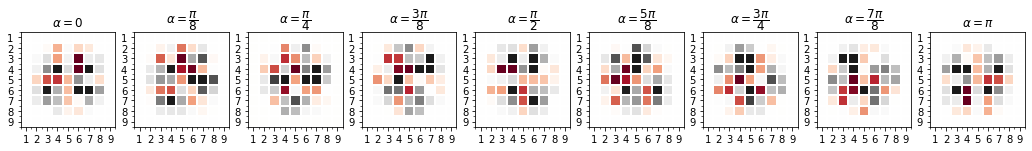

In [235]:
Wnoise = torch.randn((50,1,base.base.shape[0]))

def select_harmonic(w, har):
    if isinstance(har, int):
        har = (har,)
    for i in range(base.K):
        if i not in har:
            w[..., base.idx_real(k=i)] = 0
            w[..., base.idx_imag(k=i)] = 0

select_harmonic(w, (1))
            
fig, axs = plt.subplots(1,N+1)
noise_rot = []
for i in range(N+1):
    r = base.conv2d(I,Wnoise, alpha=alphas[i])[0]
    plot_filter(r[0], plot=axs[i], vmax=1)
    axs[i].set_title(f'$\\alpha = {repr_pi_fraction(i,N)}$')
    noise_rot += [r]
noise_rot = torch.stack(noise_rot)

### Vectorial Attention 

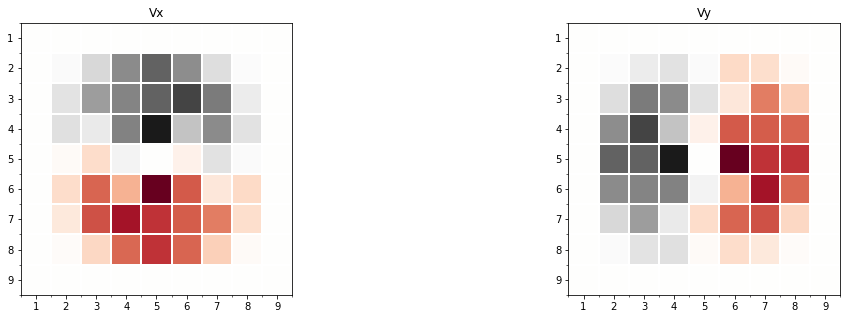

In [233]:
ortho_base = OrthoKernelBase.create_radial(5, oversample=100)
VANILLA = False
w = torch.ones((1,1,ortho_base.K*2)) if VANILLA else ortho_base.init_weights(1,1)

#k = 5
#w = torch.Tensor([[[0]*k+[1]+[0]*(8-k-1)]])

r = ortho_base.ortho_conv2d(I, w).squeeze()
fig, axs = plt.subplots(1,2)
for i, ax in enumerate(axs):
    plot_filter(r[i], plot=ax)
    axs[i].set_title(['Vx', 'Vy'][i])

alpha (rad): tensor([0.000, 0.375, 0.759, 1.163, 1.571, 1.946, 2.330, 2.734, 3.142])
alpha diff (deg): tensor([     0.000,     -1.001,     -1.526,     -0.865,      0.000,     -1.001,
            -1.526,     -0.865,     -0.000])
rho: tensor([1.000, 0.986, 0.955, 0.957, 1.000, 0.986, 0.955, 0.957, 1.000])
max alpha diff (deg): 1.53, rho std: 0.0224


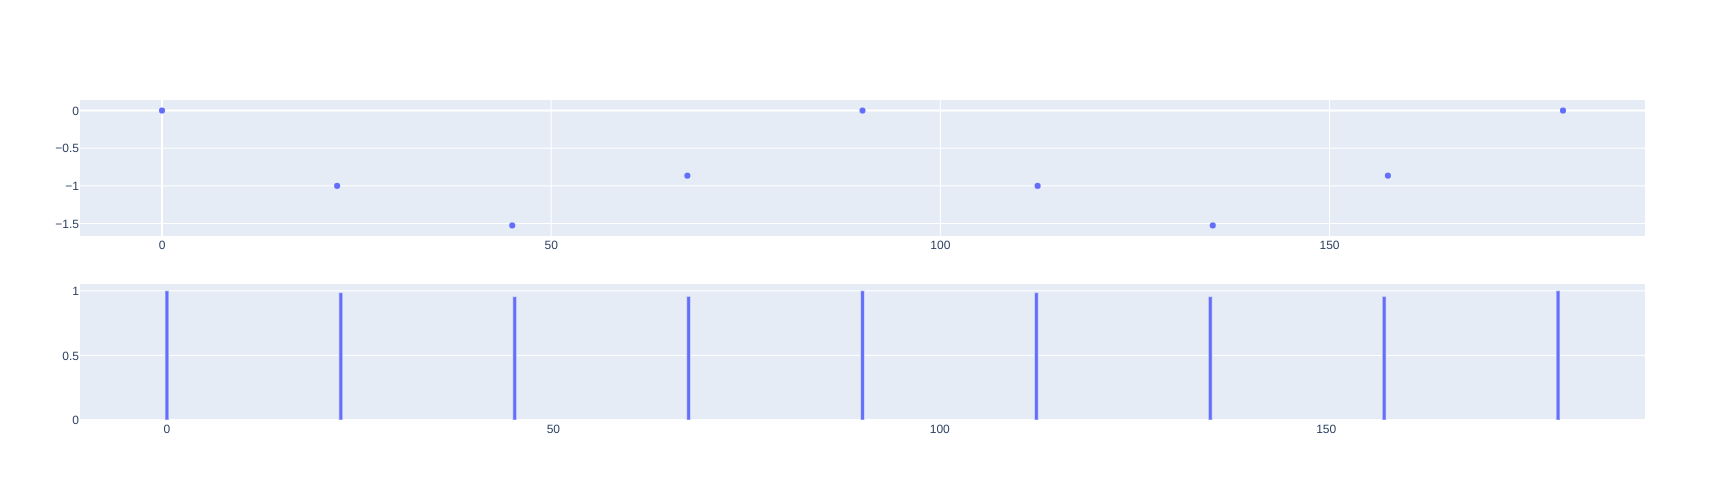

In [236]:
v = ortho_base.ortho_conv2d(diamond_rot[:,None], w, padding='valid')[...,0,1,1]
alpha = torch.atan2(v[1], v[0])
rho = torch.linalg.norm(v, dim=0)
alpha_diff = as_angle(alpha-alpha[0,None]-torch.Tensor(alphas))*180/np.pi
rho_ratio = rho/(rho[0,None]+1e-8)


print('alpha (rad):', (alpha-alpha[0,None])%(2*np.pi))
print('alpha diff (deg):', alpha_diff)
print('rho:', rho_ratio)
print(f'max alpha diff (deg): {abs(alpha_diff).max():.2f}, rho std: {rho.std():.4f}')

fig = make_subplots(2)
fig.add_trace(px.scatter(x=alphas*180/np.pi, y=alpha_diff).data[0], row=1, col=1)
fig.add_trace(px.bar(x=alphas*180/np.pi, y=rho_ratio).data[0], row=2, col=1)
fig.update_layout(height=500)
fig.update_traces(row=2, width=0.5)

alpha (deg): tensor([  0.000,  22.733,  46.989,  67.341,  90.000, 105.533, 122.589, 150.141,
         21.600])
alpha diff (deg): tensor([     0.000,      0.233,      1.989,     -0.159,     -0.000,      0.233,
             1.989,     -0.159,      0.000])
rho ratio: tensor([1.000, 0.991, 1.032, 1.019, 1.000, 0.991, 1.032, 1.019, 1.000])
max alpha diff (deg): 104.43, rho std: 0.2554


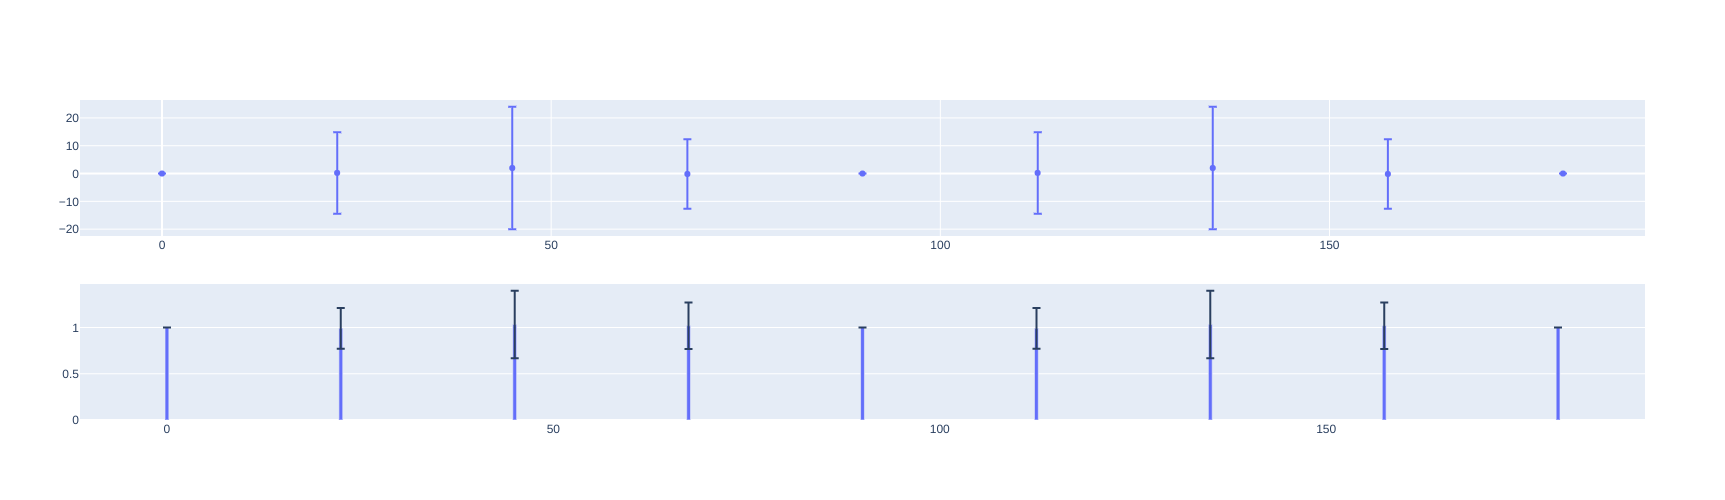

In [237]:
# w = ortho_base.init_weights(1,1)
v = ortho_base.ortho_conv2d(noise_rot.flatten(end_dim=1)[:, None], w, padding='valid')[...,1,1].reshape((2,9,noise_rot.shape[1]))#[...,5,None]
alpha = torch.atan2(v[1], v[0])
rho = torch.linalg.norm(v, dim=0)
alpha_diff = as_angle(alpha-alpha[0,None]-torch.Tensor(alphas)[:,None,])*180/np.pi
rho_ratio = rho/(rho[0,None]+1e-8)

print('alpha (deg):', (as_angle(alpha-alpha[0,None])*180/np.pi).mean(1).flatten())
print('alpha diff (deg):', alpha_diff.mean(1).flatten())
print('rho ratio:', rho_ratio.mean(1).flatten())
print(f'max alpha diff (deg): {abs(alpha_diff).max():.2f}, rho std: {rho.std():.4f}')

fig = make_subplots(2)
fig.add_trace(px.scatter(x=alphas*180/np.pi, y=alpha_diff.mean(1), error_y=alpha_diff.std(1)).data[0], row=1, col=1)
fig.add_trace(px.bar(x=alphas*180/np.pi, y=rho_ratio.mean(1), error_y=rho_ratio.std(1)).data[0], row=2, col=1)
fig.update_layout(height=500)
fig.update_traces(row=2, width=0.5)

In [172]:
alphas.shape

(9,)